# Exploring Copernicus Global Land Data with openEO

This notebook show a basic example on how openEO can be used to explore Copernicus Global Land data around Addis Ababa in Ethiopia.

## Import openEO Python client library

Make sure the openEO Python client library is installed in the (virtual) environment you are working on. 
The library is very straightforward to install with `pip install openeo`

In [1]:
import openeo

openeo.client_version()

'0.9.2'

## Connect to openEO back-end

We start with connecting to the desired openEO back-end.
To be identifiable as a user, you have to authenticate, which is implemented with the OpenID Connect standard, using EGI Check-In.
This approach allows you to reuse an existing account (e.g. your institution or a social account), instead of having to register yet another account.


In [2]:
con = openeo.connect(
    url="openeo.vito.be"
)
con.authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


<Connection to 'https://openeo.vito.be/openeo/1.0/' with BearerAuth>

## Copernicus Global Land Collection

In openEO, Earth observation data sources are organised in collections. 
To access the Copernicus Global Land data set, we have to use the correct collection id.

In [3]:
collection_id = "CGLS_NDVI300_V1_GLOBAL"

We can easily inspect the collection's metadata in this jupyter notebook like this:

In [4]:
con.describe_collection(collection_id)

{'cube:dimensions': {'bands': {'type': 'bands', 'values': ['ndvi']},
  't': {'extent': ['2014-01-01T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'step': 0.00297619047619,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'step': 0.00297619047619,
   'type': 'spatial'}},
 'description': 'Global NDVI at 300m resolution, 10-daily. The Normalized Difference Vegetation Index (NDVI) is an indicator of the greenness of the biomes. As such, it is closely linked to the FAPAR.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2014-01-01T00:00:00Z', None]]}},
 'id': 'CGLS_NDVI300_V1_GLOBAL',
 'license': 'free',
 'links': [{'href': 'https://land.copernicus.eu/global/products/ndvi',
   'rel': 'alternate',
   'title': 'Product web page.'}],
 'stac_extensions': ['datacube'],
 'stac_version': '0.9.0',
 'summaries': {},
 'title': 'Copernicus Global Land NDVI product V1, 300m resolution, 10-daily'}

## Download a small data slice

Given a certain temporal and spacial range, we can easily download a small slice of this collection

In [5]:
temporal_extent = ["2019-04-01", "2019-06-30"]
# Region around Ethiopia's Capital Addis Ababa in Longitude-Latitude coordinates
spatial_extent = {"west": 38.6, "south": 8.7, "east": 39.0, "north": 9.15}

First, we construct a data cube object. This is done locally in our notebook. No data requests are being done here, this only happens when we actually execute or download the data cube (see lower).

In [6]:
cube = con.load_collection(
    collection_id, 
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent
)

Because the data size is pretty small and we just want the data without any additional processing, we can download it synchronously.
For larger data queries or heavier processing, it is generally recommended to use (asynchronous) batch jobs instead of synchronous downloads.

Let's download it in NetCDF format, so we can easily inspect additional metadata:

In [7]:
%%time 
cube.download("AddisAbaba-dn.nc")

CPU times: user 107 ms, sys: 59.2 ms, total: 167 ms
Wall time: 7.01 s


## Inspect downloaded data

To inspect the downloaded data, we import a couple of helper libraries.

In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import math

Now, load the NetCDF file as an xarray Dataset

In [9]:
data = xr.load_dataset("AddisAbaba-dn.nc", engine="h5netcdf")
data

<xarray.Dataset>
Dimensions:  (t: 9, x: 512, y: 768)
Coordinates:
  * t        (t) datetime64[ns] 2019-04-01 2019-04-11 ... 2019-06-11 2019-06-21
  * x        (x) float64 37.97 37.97 37.98 37.98 ... 39.37 39.37 39.37 39.37
  * y        (y) float64 9.491 9.49 9.489 9.487 9.486 ... 8.442 8.441 8.44 8.438
Data variables:
    crs      |S1 b''
    ndvi     (t, y, x) uint8 86 91 79 74 76 80 77 ... 126 138 126 127 142 142
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

What timestamps are in our time series?

In [10]:
data.t.values

array(['2019-04-01T00:00:00.000000000', '2019-04-11T00:00:00.000000000',
       '2019-04-21T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-05-11T00:00:00.000000000', '2019-05-21T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-06-11T00:00:00.000000000',
       '2019-06-21T00:00:00.000000000'], dtype='datetime64[ns]')

Let's pick the `ndvi` data variable and check it's distribution.

In [11]:
ndvi = data["ndvi"]

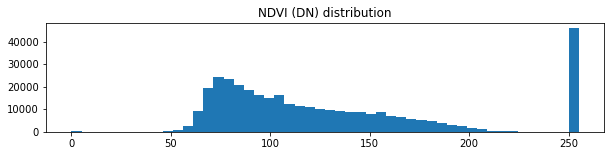

In [12]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.hist(ndvi.values.flat[::10], bins=50)
ax.set_title("NDVI (DN) distribution");

Apparently we got the digital number (DN) values here instead of physical NDVI values. 
Also note the peak at value 255, which is used for encoding the no-data value in `uint8`.

## Rescale to physical values

The collection metadata links to the product information, including the [mapping between digital number values and physical values](https://land.copernicus.eu/global/products/ndvi):

    PV = 1/250 * DN - 0.08

We can easily include this rescaling in our desired data cube as follows.
Notice how the openEO Python client library allows to specify the linear rescaling function succinctly as a Python `lambda` expression.

In [13]:
cube = con.load_collection(
    collection_id, 
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent
)
cube = cube.apply(lambda x: x / 250 - 0.08)

Download again and inspect the data.

In [14]:
%%time 
cube.download("AddisAbaba.nc")

CPU times: user 134 ms, sys: 47.8 ms, total: 182 ms
Wall time: 8.86 s


In [15]:
data = xr.load_dataset("AddisAbaba.nc", engine="h5netcdf")
ndvi = data["ndvi"]

The distribution of the NDVI values now properly falls in the range we expect.

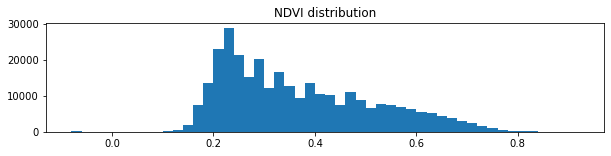

In [16]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.hist(ndvi.values.flat[::10], bins=50)
ax.set_title("NDVI distribution");

## Show NDVI maps


To show the NDVI maps, first define plot function to take care of the annoying details.

In [17]:
def imshow(ax, ndvi, add_colorbar=False):    
    # Render
    im = ax.imshow(ndvi, vmin=-0.08, vmax=0.8, cmap="YlGn")

    # Finetune decoration
    ax.set_title(np.datetime_as_string(ndvi.t, unit="D"))
    ax.set_xticks([0, ndvi.shape[1] - 1])
    ax.set_xticklabels(["{x:.2f}".format(x=x.item()) for x in [ndvi.x[0], ndvi.x[-1]]], rotation="vertical")
    ax.set_yticks([0, ndvi.shape[0] - 1])
    ax.set_yticklabels(["{y:.2f}".format(y=y.item()) for y in [ndvi.y[0], ndvi.y[-1]]])
    px_x = float(ndvi.x.max() - ndvi.x.min()) / ndvi.shape[1]
    px_y = float(ndvi.y.max() - ndvi.y.min()) / ndvi.shape[0]
    ax.set_aspect(px_y/px_x)

    if add_colorbar:
        plt.colorbar(im)

Show the date with least no-data pixels

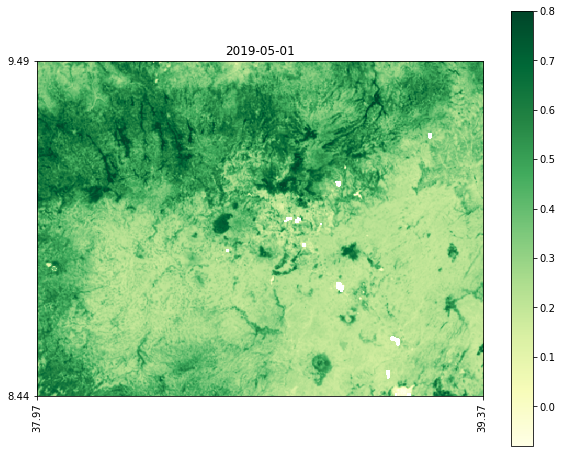

In [23]:
least_no_data = ndvi.notnull().sum(dim=["x", "y"]).argmax().item()

fig, ax = plt.subplots(figsize=(10, 8))
imshow(ax, ndvi.isel(t=least_no_data), add_colorbar=True)

Show an NDVI map for each timestamp

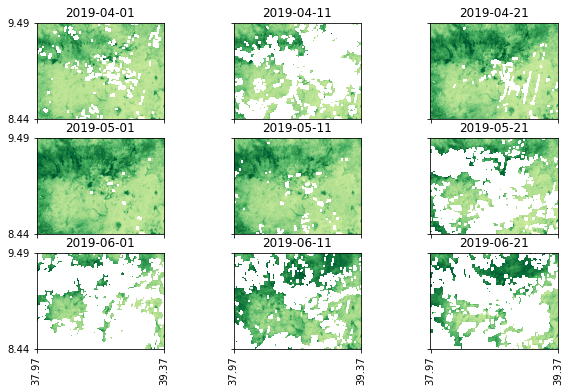

In [24]:
nrows = int(math.sqrt(ndvi.sizes["t"]))
ncols = math.ceil(ndvi.sizes["t"] / nrows)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, sharex=True, sharey=True, figsize=(10, 6))
for timestamp, ax in zip(ndvi.t, axes.flat):
    imshow(ax=ax, ndvi=ndvi.sel(t=timestamp))


## Aggregated timeseries

As a next step we will construct a timeseries of spatially aggregated NDVI values.
As an example we define two polygons, 
one covering a part of the Menagesha National Forest
and another one covering an urban region of Addis Ababa.

In [20]:
geometries = {
    "type": "FeatureCollection",
    "features": [
        { "type": "Feature", "properties": { "name": "forest" }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 38.52773699371609, 8.981374938900579 ], [ 38.546429297364845, 9.000605150568004 ], [ 38.571442020232965, 8.966447991382509 ], [ 38.546025866350845, 8.94641091768708 ], [ 38.546025866350845, 8.94641091768708 ], [ 38.52773699371609, 8.981374938900579 ] ] ] ] } },
        { "type": "Feature", "properties": { "name": "urban" }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 38.726874625986383, 9.049376356395376 ], [ 38.777513399403439, 9.046998949192696 ], [ 38.78512110245201, 8.988990213447337 ], [ 38.727112366706649, 9.011100100432248 ], [ 38.726874625986383, 9.049376356395376 ] ] ] ] } },
    ]
}

Like before we load an initial data cube, with a temporal extent and rescaling. 
Because we'll do spatial aggregation in a next step, we don't need to specify a spatial extent explicitly at this point.

In [21]:
temporal_extent = ["2018-01-01", "2020-12-31"]

cube = (
    con.load_collection(
        collection_id, 
        temporal_extent=temporal_extent,
    )
    .apply(lambda x: x / 250 - 0.08)
)

On this data cube, we apply the `aggregate_spatial` process to do spatial aggregation over the geometries we defined earlier.
We'll just aggregate with the `mean` process, which we can simply specify as a string.

In [22]:
timeseries = cube.aggregate_spatial(geometries=geometries, reducer="mean")

We can now trigger the execution of this processing pipeline by downloading the timeseries, which will result in a JSON file.

In [23]:
%%time
timeseries.download("mean-ndvi-timeseries.json")

CPU times: user 11 ms, sys: 682 µs, total: 11.6 ms
Wall time: 14.1 s


The openEO Python client library provides a helper function to convert the JSON structure directly to a pandas DataFrame.

In [24]:
import json
from openeo.rest.conversions import timeseries_json_to_pandas

with open("mean-ndvi-timeseries.json") as f:
    ts = timeseries_json_to_pandas(json.load(f))

# A bit of additional data massaging.
ts = ts.dropna()
ts.columns = ["forest", "urban"]
ts.index = pd.to_datetime(ts.index)

ts.tail()

,forest,urban
date,,
2020-11-11 00:00:00+00:00,0.765879,0.251725
2020-11-21 00:00:00+00:00,0.745201,0.236908
2020-12-01 00:00:00+00:00,0.721278,0.236217
2020-12-11 00:00:00+00:00,0.713866,0.234934
2020-12-21 00:00:00+00:00,0.719936,0.241868


We can now easily make a NDVI timeseries plot:

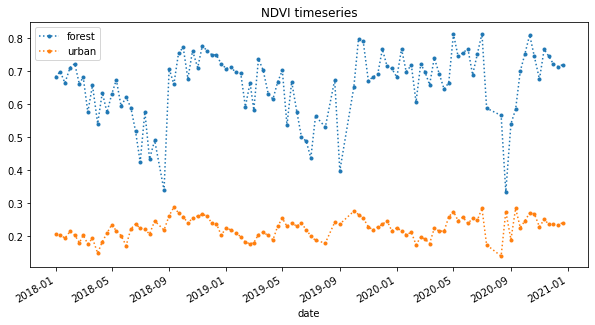

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ts.plot(style='.:', ax=ax)
ax.set_title("NDVI timeseries");